In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
import seaborn as sns
import numpy as np
import datetime
import gtfstk as gt
%matplotlib inline
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42

In [2]:
# Read in data
OTP_data=pd.read_csv(r"N:\Planning - New File Structure\Performance\OTP-Q3FY17-FR.csv")
OTP_data['DepartTime']=pd.to_datetime(OTP_data['DepartTime'])
OTP_data['ScheduledStopTime']=pd.to_datetime(OTP_data['ScheduledStopTime'])
OTP_data['ArriveTime']=pd.to_datetime(OTP_data['ArriveTime'])

In [3]:
# Calculate difference between scheduled and actual departure time
OTP_data['Relative']=OTP_data['DepartTime']-OTP_data['ScheduledStopTime']

In [4]:
# Identify bad data points
OTP_data=OTP_data.dropna(subset=['DepartTime'])
OTP_data['Invalid']=np.logical_or(np.logical_or(OTP_data['Relative']>datetime.timedelta(hours=2),OTP_data['Relative']<datetime.timedelta(hours=1)),(OTP_data['DepartTime']<OTP_data['ArriveTime']))

In [5]:
# Identify terminals
OTP_data['Start']=np.where(OTP_data['ScheduledTripStart']==OTP_data['ScheduledStopTime'],True,False)
OTP_data['End']=np.where(OTP_data['ScheduledTripEnd']==OTP_data['ScheduledStopTime'],True,False)
OTP_data['Terminal']=np.logical_or(OTP_data['Start'],OTP_data['End'])

In [6]:
OTP_data.drop(['Invalid'],axis=1,inplace=True)

In [7]:
# Format data for use in graphs and such
OTP_data['date']=OTP_data['ScheduledStopTime'].dt.date
OTP_data['time']=OTP_data['ScheduledStopTime'].dt.time
OTP_data['hour']=[r.hour for r in OTP_data.time]
OTP_data['minutes']=[r.hour*60+r.minute for r in OTP_data.time]
OTP_data['ToDdec']=OTP_data['minutes']/60
OTP_data['RelArrive']=OTP_data['ArriveTime']-OTP_data['ScheduledStopTime']
OTP_data['RelArrNum']=(pd.to_numeric(OTP_data['RelArrive'],downcast='integer'))/60000000000
OTP_data['RelNum']=(pd.to_numeric(OTP_data['Relative'],downcast='integer'))/60000000000
OTP_data['RelNum'].loc[OTP_data['End']]=OTP_data['RelArrNum']
OTP_data.sort_values(by='MasterRouteName',inplace=True)

c:\users\bparker\appdata\local\conda\conda\envs\py3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
# Classify as early, on time, or late
OTP_data['Early']=np.where(OTP_data['RelNum']<-1,True,False)
OTP_data['Late']=np.where(OTP_data['RelNum']>5,True,False)
OTP_data['OnTime']=np.logical_and(OTP_data['Early']==False,OTP_data['Late']==False)

In [9]:
# Make a column for better labeling purposes
OTP_data['OnTimeLabel']='Not On Time'
OTP_data['OnTimeLabel'].loc[OTP_data['OnTime']]='On Time'

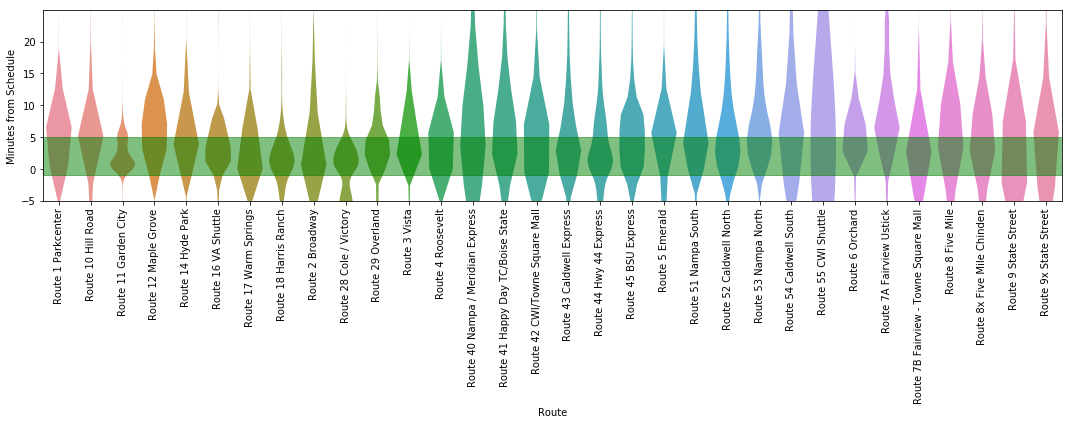

In [10]:
# Draw violin plot
# These look slightly different than as published in annual report. I updated seaborn and I suspect that the drawing function changed slightly.
f, ax = plt.subplots(figsize=(15,6))
violin=sns.violinplot(x=OTP_data.MasterRouteName,y=OTP_data.RelNum,ax=ax,scale="width",linewidth=0)
plt.xticks(rotation=90)
plt.yticks(np.arange(-5, 25, step=5))
plt.ylim(-5,25)
plt.ylabel("Minutes from Schedule")
plt.xlabel("Route")
plt.axhspan(-1,5,color='green',alpha=.5)
plt.tight_layout()

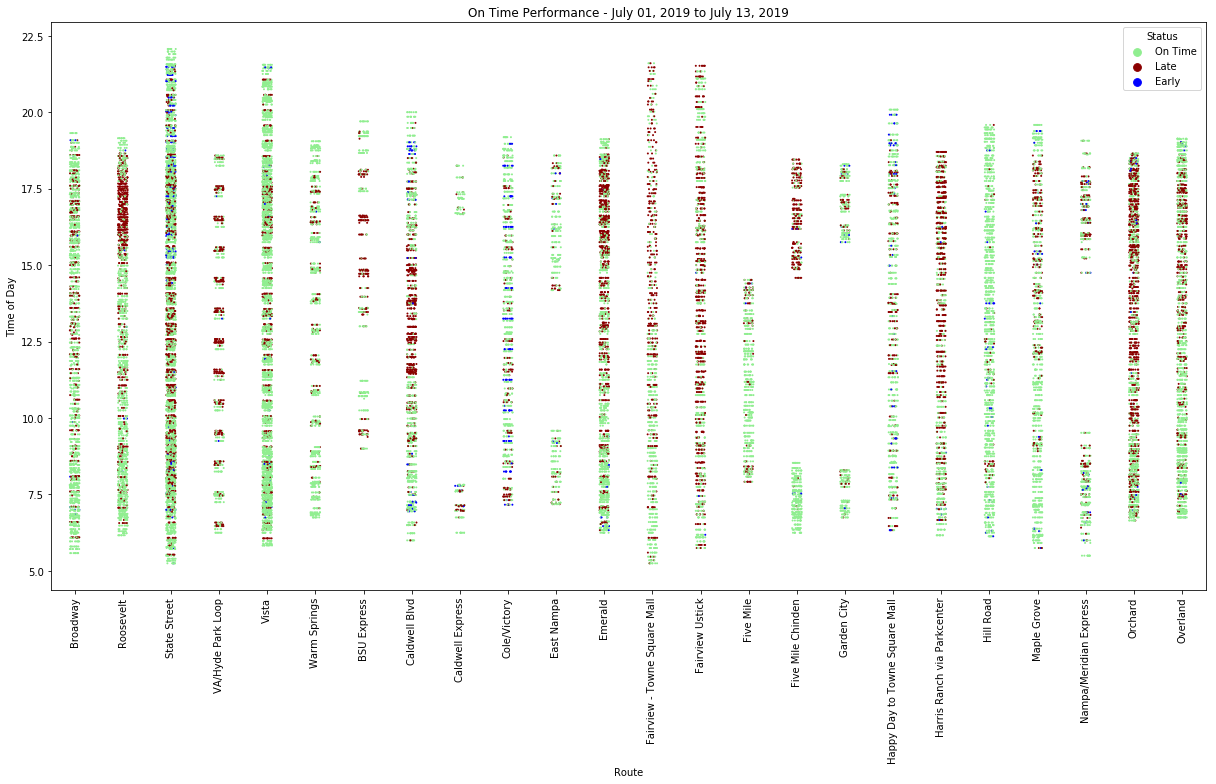

In [25]:
def plotToDOTP(route_short_name,save_file=None):
    df=pd.read_csv(r"N:\Planning - New File Structure\Performance\FY19 OTP\July_1_July_13_1_5\CSV\OTP_Detail_All_Routes.csv"
                   ,parse_dates=['ScheduledStopTime'])
    df['date']=df['ScheduledStopTime'].dt.date
    df['time']=df['ScheduledStopTime'].dt.time
    df['hour']=[r.hour for r in df.time]
    df['minutes']=[r.hour*60+r.minute for r in df.time]
    df['ToDdec']=df['minutes']/60
    df['Early']=df['MinutesEarly']>0
    df['On Time']=(df['MinutesEarly']==0)&(df['MinutesLate']==0)
    df['Late']=df['MinutesLate']>0
    df['Status']='On Time'
    df.loc[df.Early,'Status']='Early'
    df.loc[df.Late,'Status']='Late'
    f, ax=plt.subplots(figsize=(17,11))
    plot=sns.stripplot(x=df.MasterRouteName,y=df.ToDdec,size=2,hue=df.Status,palette={'Early':'blue','On Time':'lightgreen','Late':'darkred'},ax=ax)
    plt.xticks(rotation=90)
    plt.xlabel("Route")
    plt.ylabel("Time of Day")
    plt.title("On Time Performance - {} to {}".format(df.date.min().strftime("%B %d, %Y"),df.date.max().strftime("%B %d, %Y")))
    plt.tight_layout()
    return plot
plot=plotToDOTP('All')
plot.figure.savefig(r"N:\Planning - New File Structure\Performance\FY19 OTP\plot_test.jpg")

In [11]:
# Export to clean up in Illustrator
# violin.figure.savefig(r"N:\Planning - New File Structure\Performance\Annual Report\VRT_ontime_violin.pdf",transparent=True)

In [12]:
# Select Ada County Routes
Ada=OTP_data.loc[(OTP_data['MasterRouteName']=='Route 1 Parkcenter')
                 |(OTP_data['MasterRouteName']=='Route 10 Hill Road')
                 |(OTP_data['MasterRouteName']=='Route 11 Garden City')
                |(OTP_data['MasterRouteName']=='Route 14 Hyde Park')
                 |(OTP_data['MasterRouteName']=='Route 16 VA Shuttle')
                |(OTP_data['MasterRouteName']=='Route 17 Warm Springs')
                |(OTP_data['MasterRouteName']=='Route 18 Harris Ranch')
                 |(OTP_data['MasterRouteName']=='Route 2 Broadway')
                |(OTP_data['MasterRouteName']=='Route 28 Cole / Victory')
                |(OTP_data['MasterRouteName']=='Route 29 Overland')
                |(OTP_data['MasterRouteName']=='Route 3 Vista')
                |(OTP_data['MasterRouteName']=='Route 4 Roosevelt')
                |(OTP_data['MasterRouteName']=='Route 5 Emerald')
                |(OTP_data['MasterRouteName']=='Route 6 Orchard')
                |(OTP_data['MasterRouteName']=='Route 7A Fairview Ustick')
                |(OTP_data['MasterRouteName']=='Route 7B Fairview - Towne Square Mall')
                |(OTP_data['MasterRouteName']=='Route 7B Fairview Towne Square Mall')
                |(OTP_data['MasterRouteName']=='Route 8 Five Mile')
                |(OTP_data['MasterRouteName']=='Route 8x Five Mile Chinden')
                |(OTP_data['MasterRouteName']=='Route 9 State Street')
                |(OTP_data['MasterRouteName']=='Route 9x State Street')]

In [13]:
# Select Canyon County Routes
Canyon=OTP_data.loc[(OTP_data['MasterRouteName']=='Route 51 East Nampa')
                   |(OTP_data['MasterRouteName']=='Route 51 Nampa South')
                    |(OTP_data['MasterRouteName']=='Route 52 Caldwell Blvd')
                    |(OTP_data['MasterRouteName']=='Route 52 Caldwell North')
                    |(OTP_data['MasterRouteName']=='Route 53 Nampa North')
                    |(OTP_data['MasterRouteName']=='Route 54 Caldwell South')
                   |(OTP_data['MasterRouteName']=='Route 55 CWI Shuttle')]

In [14]:
# Select Intercounty Routes
Intercounty=OTP_data.loc[(OTP_data['MasterRouteName']=='Route 40 Nampa/Meridian Express')
                        |(OTP_data['MasterRouteName']=='Route 41 Happy Day to Towne Square Mall')
                         |(OTP_data['MasterRouteName']=='Route 42 CWI/Towne Square Mall')
                        |(OTP_data['MasterRouteName']=='Route 43 Caldwell Express')
                        |(OTP_data['MasterRouteName']=='Route 44 Hwy 44 Express')
                        |(OTP_data['MasterRouteName']=='Route 45 BSU Express')]

In [15]:
# Select Peak Hour timepoints
AdaPeak=Ada.loc[((Ada['ToDdec']>=6)&(Ada['ToDdec']<=9))|((Ada['ToDdec']>=16)&(Ada['ToDdec']<=19))]

In [16]:
CanyonPeak=Canyon.loc[((Canyon['ToDdec']>=6)&(Canyon['ToDdec']<=9))|((Canyon['ToDdec']>=16)&(Canyon['ToDdec']<=19))]

In [17]:
IntercountyPeak=Intercounty.loc[((Intercounty['ToDdec']>=6)&(Intercounty['ToDdec']<=9))|((Intercounty['ToDdec']>=16)&(Intercounty['ToDdec']<=19))]

In [18]:
# Combine to single dataframe, convert to percentages
summary=pd.DataFrame({'Early':[Ada.Early.sum(),AdaPeak.Early.sum(),Canyon.Early.sum(),CanyonPeak.Early.sum(),Intercounty.Early.sum(),IntercountyPeak.Early.sum()],'On Time':[Ada.OnTime.sum(),AdaPeak.OnTime.sum(),Canyon.OnTime.sum(),CanyonPeak.OnTime.sum(),Intercounty.OnTime.sum(),IntercountyPeak.OnTime.sum()],'Late':[Ada.Late.sum(),AdaPeak.Late.sum(),Canyon.Late.sum(),CanyonPeak.Late.sum(),Intercounty.Late.sum(),IntercountyPeak.Late.sum()]},index=['Ada County','Ada County Peak','Canyon County','Canyon County Peak','Intercounty','Intercounty Peak'])
summary['Total']=summary.sum(axis=1)
summaryPct=summary
summaryPct['EarlyPct']=round(summary['Early']/summary['Total']*100,1)
summaryPct['On TimePct']=round(summary['On Time']/summary['Total']*100,1)
summaryPct['LatePct']=round(summary['Late']/summary['Total']*100,1)
summaryPct.drop('Total',axis=1,inplace=True)
summaryPct

,Early,On Time,Late,EarlyPct,On TimePct,LatePct
Ada County,11761,95649,59574,7.0,57.3,35.7
Ada County Peak,5751,47884,30039,6.9,57.2,35.9
Canyon County,500,7569,8790,3.0,44.9,52.1
Canyon County Peak,164,3637,3869,2.1,47.4,50.4
Intercounty,853,4406,3934,9.3,47.9,42.8
Intercounty Peak,414,2219,1940,9.1,48.5,42.4


In [19]:
# Repeat process with FY17 Data